In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

/home/aditya/miniconda3/envs/trtpose/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/aditya/miniconda3/envs/trtpose/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                               transforms.RandomCrop(32, padding=1),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [8]:
import torch.utils
import torch.utils.data


trainset = torchvision.datasets.CIFAR10(root="/home/aditya/Deep_Learning_Projects/Revision_projects", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(dataset = trainset, shuffle=True, batch_size=100, num_workers=2)
testset = torchvision.datasets.CIFAR10(root="/home/aditya/Deep_Learning_Projects/Revision_projects", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(dataset = testset, shuffle=False, batch_size=100, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


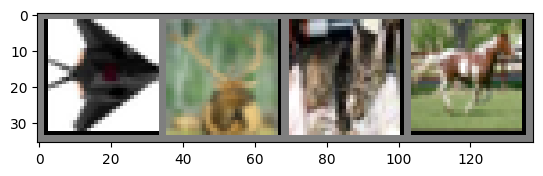

plane deer cat horse


In [36]:
import matplotlib.pyplot as plt
import numpy as np
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

detaiter = iter(trainloader)
images, labels = detaiter.next()

imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))

In [37]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size= 3, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size= 3, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size= 3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size= 2, stride = 2)
        self.fc1 = nn.Linear(in_features=128*4*4, out_features=512)
        self.fc2 = nn.Linear(in_features=512,out_features=10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128*4*4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        return x

In [48]:
from torch.utils.tensorboard import SummaryWriter
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
writer = SummaryWriter()

In [50]:
def validate_model(net, testloader, criterion):
    net.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
        net.train()
        return validation_loss / len(testloader)

In [52]:
def train_model(net, trainloader, criterion, optimizer, n_epoch = 10, patience = 2):
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(n_epoch):
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            if i%100==00:
                print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}')
                writer.add_scalar('training loss', running_loss/100, epoch*len(trainloader) + i)
                running_loss = 0
            
        validation_loss = validate_model(net, testloader, criterion)
        writer.add_scalar('validation', validation_loss/100, epoch*len(trainloader) + i)
        if validation_loss < best_loss:
            best_loss = validation_loss
            patience_counter = 0
            torch.save(net.state_dict(), 'Best_model.pth')
        else:
            patience_counter +=1

        if patience_counter >= patience:
            print("Early Stopping")
            break
    print("Finished training")
    writer.close()


In [53]:
train_model(net, trainloader, criterion, optimizer, n_epoch = 50)

[1, 1] loss: 0.023
[1, 101] loss: 2.302
[1, 201] loss: 2.298
[1, 301] loss: 2.295
[1, 401] loss: 2.290
[2, 1] loss: 0.023
[2, 101] loss: 2.267
[2, 201] loss: 2.252
[2, 301] loss: 2.225
[2, 401] loss: 2.185
[3, 1] loss: 0.020
[3, 101] loss: 2.087
[3, 201] loss: 2.041
[3, 301] loss: 2.011
[3, 401] loss: 1.978
[4, 1] loss: 0.019
[4, 101] loss: 1.925
[4, 201] loss: 1.891
[4, 301] loss: 1.883
[4, 401] loss: 1.838
[5, 1] loss: 0.018
[5, 101] loss: 1.796
[5, 201] loss: 1.768
[5, 301] loss: 1.732
[5, 401] loss: 1.715
[6, 1] loss: 0.018
[6, 101] loss: 1.649
[6, 201] loss: 1.659
[6, 301] loss: 1.629
[6, 401] loss: 1.595
[7, 1] loss: 0.016
[7, 101] loss: 1.577
[7, 201] loss: 1.558
[7, 301] loss: 1.534
[7, 401] loss: 1.533
[8, 1] loss: 0.014
[8, 101] loss: 1.514
[8, 201] loss: 1.486
[8, 301] loss: 1.470
[8, 401] loss: 1.475
[9, 1] loss: 0.016
[9, 101] loss: 1.464
[9, 201] loss: 1.458
[9, 301] loss: 1.435
[9, 401] loss: 1.427
[10, 1] loss: 0.014
[10, 101] loss: 1.396
[10, 201] loss: 1.394
[10, 301]

In [64]:
net.load_state_dict(torch.load('Best_model.pth'))
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # print(labels.device)
        # print(images.device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 1000 test images: {100*correct / total} %')

Accuracy of the network on the 1000 test images: 73.3 %
